# Spectrogram Generation

This notebook is intended as some kind of playground, to further develop the capabilities of the `Spectrogram` class, which is used to generate training (and evaluation) samples for the FCN.

## Preliminaries

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import time

import numpy as np
import h5py
import librosa

from matplotlib import mlab
from matplotlib import gridspec
from scipy.interpolate import interp1d

## Create pretty-ish plots of standard spectrograms

In [3]:
def forceAspect(ax,aspect=1):
    """
    Stolen from here: https://stackoverflow.com/a/7968690/4100721
    Sometimes works to produce plots with the desired aspect ratio.
    """
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)

In [4]:
def make_plot(image, label, vmin=None, vmax=None):

    # Fix the size of figure as a whole
    plt.gcf().set_size_inches(18, 6, forward=True)
    
    # Define a grid to fix the heigh ratios of the subplots
    gs = gridspec.GridSpec(2, 1, height_ratios=[20, 1])
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1], sharex=ax1)
    
    # Plot the spectrogram
    ax1.imshow(image, origin="lower", cmap="Greys_r", interpolation="none",  
               vmin=vmin, vmax=vmax)
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.xaxis.set_ticks_position('none')
    ax1.yaxis.set_ticks_position('none')
    forceAspect(ax1, aspect=3.39)
    
    # Plot the vector indicating where there was an injection
    ax2.imshow(label.reshape(1, -1), cmap="Greys")
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])
    ax2.xaxis.set_ticks_position('none')
    ax2.yaxis.set_ticks_position('none')
    forceAspect(ax2, aspect=72)
    
    plt.tight_layout()
    plt.gcf().subplots_adjust(hspace=0.05)
    plt.show()

## Add color to generated waveforms

In [5]:
def add_color(signal_t, psd, sampling_rate=4096):
    """
    Take a signal in the time domain, and a precalculated Power Spectral
    Density, and color the signal according to the given PSD.

    Args:
        signal_t: A signal in time domain (i.e. a 1D numpy array)
        psd: A Power Spectral Density, e.g. calculated from the detector noise.
            Should be a function: psd(frequency)
        sampling_rate: Sampling rate of signal_t

    Returns: color_signal_t, the colored signal in the time domain.
    """

    # First set some parameters for computing power spectra
    n = len(signal_t)
    dt = 1./sampling_rate

    # Go into Fourier (frequency) space: signal_t -> signal_f
    frequencies = np.fft.rfftfreq(n, dt)
    signal_f = np.fft.rfft(signal_t)

    # Divide by the given Power Spectral Density (PSD)
    # This is the 'whitening' = actually adding color
    color_signal_f = signal_f / (np.sqrt(psd(frequencies) / dt / 2.))

    # Go back into time space: color_signal_f -> color_signal_t
    color_signal_t = np.fft.irfft(color_signal_f, n=n)

    # In case we want to use a Butterworth-filter, here's how to do it:
    # bb, ab = butter(4, [20*2/4096, 300*2/4096], btype="band")
    # color_signal_t = filtfilt(bb, ab, color_signal_t)

    return color_signal_t

## Read in the real strain and calculate PSD

In [6]:
# Path to the directory where all data is stored
data_path = '/Users/timothy/Documents/Uni/01_Master/Masterarbeit/01_Code/' \
            'gw-continuous/src/data'

# -------------------------------------------------------------------------
# Read in the real strain data from the LIGO website
# -------------------------------------------------------------------------

with h5py.File(os.path.join(data_path, 'H1_2017_4096.hdf5')) as file:
    real_strain = np.array(file['strain/Strain'])

# -------------------------------------------------------------------------
# Pre-calculate the Power Spectral Density from the real strain data
# -------------------------------------------------------------------------

# Define some constants
sampling_rate = 4096     # The sampling rate for the Fourier transform?
nfft = 8192              # Bigger values yield better resolution?
dt = 1. / sampling_rate  # Inverse sampling rate

# Use matplotlib.mlab to calculate the PSD from the real strain
P_xx, freqs = mlab.psd(real_strain, NFFT=nfft, Fs=sampling_rate)

# Interpolate it linearly, so we can re-sample the spectrum at other points
psd = interp1d(freqs, P_xx)

## Load pre-computed waveforms

In [7]:
with h5py.File(os.path.join(data_path, 'samples_dist_100_300.h5')) as file:

    # Read in waveforms as well as the indices of the unusable waveforms
    waveforms = np.array(file['waveforms'])
    failed_idx = np.array(file['failed'])

    # Exclude failed waveforms right away:
    waveforms = np.array([_ for i, _ in enumerate(waveforms)
                          if i not in failed_idx])

## The `Spectrogram` class

In [8]:
class Spectrogram:

    def __init__(self, sample_length, sampling_rate, n_injections,
                 waveforms, psd, max_delta_t=0, loudness=1.0):

        self.sample_length = sample_length
        self.sampling_rate = sampling_rate
        self.n_injections = n_injections
        self.psd = psd
        self.waveforms = waveforms
        self.positions = None
        self.max_delta_t = max_delta_t
        self.loudness = loudness
        
        # Create a random time difference between the signals
        self.delta_t = 0.1 #np.random.uniform(-1*max_delta_t, max_delta_t)
        self.offset = int(self.delta_t * self.sampling_rate)

        # Create the Gaussian noises
        self.noise_H1 = self._make_noise()
        self.noise_L1 = self._make_noise()
        self.noise = np.vstack((self.noise_H1, self.noise_L1))

        # Create the signals by making some injections
        self.signal_H1, self.signal_L1, self.injections = self._make_signals()
        self.signal = np.vstack((self.signal_H1, self.signal_L1))

        # Calculate the strains as the sum of the noises and the signals
        self.strain_H1, self.strain_L1 = self._make_strains()
        self.strain = np.vstack((self.strain_H1, self.strain_L1))

        # Calculate a spectrogram from the strain
        self.spectrogram_H1, self.spectrogram_L1 = self._make_spectrograms()
        self.spectrogram = np.dstack((self.spectrogram_H1, self.spectrogram_L1))

        # Finally calculate the label for this spectrogram
        self.label_H1, self.label_L1 = self._make_labels()
        self.label = np.vstack((self.label_H1, self.label_L1))

    # -------------------------------------------------------------------------

    def _make_noise(self):
        return np.random.normal(0, 1, self.sample_length * self.sampling_rate)

    # -------------------------------------------------------------------------

    def _make_signals(self):

        # Initialize empty signals
        signal_H1 = np.zeros(self.sample_length * self.sampling_rate)
        signal_L1 = np.zeros(self.sample_length * self.sampling_rate)

        # Get the starting positions for each injection
        self.positions = np.linspace(0, 0.9*len(signal_H1), 
                                     self.n_injections + 1)
        self.positions = np.array([int((x+y)/2) for x, y in
                                   zip(self.positions, self.positions[1:])])
        
        # Initialize an empty list for the injection meta-information
        injections = []

        # Loop over all injections to be made
        for inj_number in range(self.n_injections):

            # Randomly select a waveform
            waveform_idx = np.random.randint(len(self.waveforms))
            waveform = self.waveforms[waveform_idx]

            # Add color to that waveform
            color_waveform = add_color(waveform, self.psd)[100:-50]

            # Calculate absolute and relative starting positions and lengths
            # of the waveform that is being injected
            abs_start_pos_H1 = self.positions[inj_number]
            rel_start_pos_H1 = abs_start_pos_H1 / len(signal_H1)
            abs_start_pos_L1 = self.positions[inj_number] + self.offset
            rel_start_pos_L1 = abs_start_pos_L1 / len(signal_H1)
            
            abs_waveform_length = len(color_waveform)
            rel_waveform_length = (abs_waveform_length / len(signal_H1))

            # Calculate the absolute end position of the injection
            abs_end_pos_H1 = abs_start_pos_H1 + abs_waveform_length
            abs_end_pos_L1 = abs_start_pos_L1 + abs_waveform_length

            # Make the injection, i.e. add the waveform to the signal
            signal_H1[abs_start_pos_H1:abs_end_pos_H1] += (self.loudness *
                                                           color_waveform)
            signal_L1[abs_start_pos_L1:abs_end_pos_L1] += (self.loudness *
                                                           color_waveform)

            # Store information about the injection we just made
            injections.append(dict(waveform_idx=waveform_idx,
                                   rel_start_pos_H1=rel_start_pos_H1,
                                   rel_start_pos_L1=rel_start_pos_L1,
                                   rel_waveform_length=rel_waveform_length))

        return signal_H1, signal_L1, injections

    # -------------------------------------------------------------------------

    def _make_strains(self):
        
        strain_H1 = self.noise_H1 + self.signal_H1
        strain_L1 = self.noise_L1 + self.signal_L1
        
        return strain_H1, strain_L1

        
    # -------------------------------------------------------------------------

    def _make_spectrograms(self, log_scale=True):

        # Essentially curry the make_spectrogram() function of librosa, because
        # we need to call it twice and this is just more readable
        def make_spectrogram(strain):
             return librosa.feature.melspectrogram(strain, sr=4096, n_fft=1024,
                                                   hop_length=64, n_mels=64,
                                                   fmin=0, fmax=400)
        
        # Calculate the spectrograms
        spectrogram_H1 = make_spectrogram(self.strain_H1)
        spectrogram_L1 = make_spectrogram(self.strain_L1)
        
        # If we are using log scale spectrograms, calculate them and return
        if log_scale:
            log_spectrogram_H1 = librosa.logamplitude(spectrogram_H1, ref=1.0)
            log_spectrogram_L1 = librosa.logamplitude(spectrogram_L1, ref=1.0)
            return log_spectrogram_H1, log_spectrogram_L1
        return spectrogram_H1, spectrogram_L1

    # -------------------------------------------------------------------------

    def _make_labels(self):

        # Get the lengths of the spectrograms
        spectrogram_length_H1 = self.spectrogram_H1.shape[1]
        spectrogram_length_L1 = self.spectrogram_L1.shape[1]

        # Initialize and empty label
        label_H1 = np.zeros(spectrogram_length_H1)
        label_L1 = np.zeros(spectrogram_length_H1)

        # Loop over the injections we made and add set the label to 1 at
        # every point where there should be an injection present
        for injection in self.injections:
            
            # Calculate start and end positions
            start_H1 = injection['rel_start_pos_H1'] * spectrogram_length_H1
            start_L1 = injection['rel_start_pos_L1'] * spectrogram_length_H1
            end_H1 = start_H1 + (injection['rel_waveform_length'] * 
                                 spectrogram_length_H1)
            end_L1 = start_L1 + (injection['rel_waveform_length'] * 
                                 spectrogram_length_L1)
            
            # Actually set the labels
            label_H1[int(start_H1):int(end_H1)] += 1
            label_L1[int(start_L1):int(end_L1)] += 1
            
            # If we want to include fuzzy labels, this would be the place to do it!

        return label_H1, label_L1

## Start creating spectrograms

In [9]:
# Fix some constants for the sample generator
sample_length = 10
sampling_rate = 4096
n_injections = 4
max_delta_t = 0.1
loudness = 1

Spectrogram for H1:


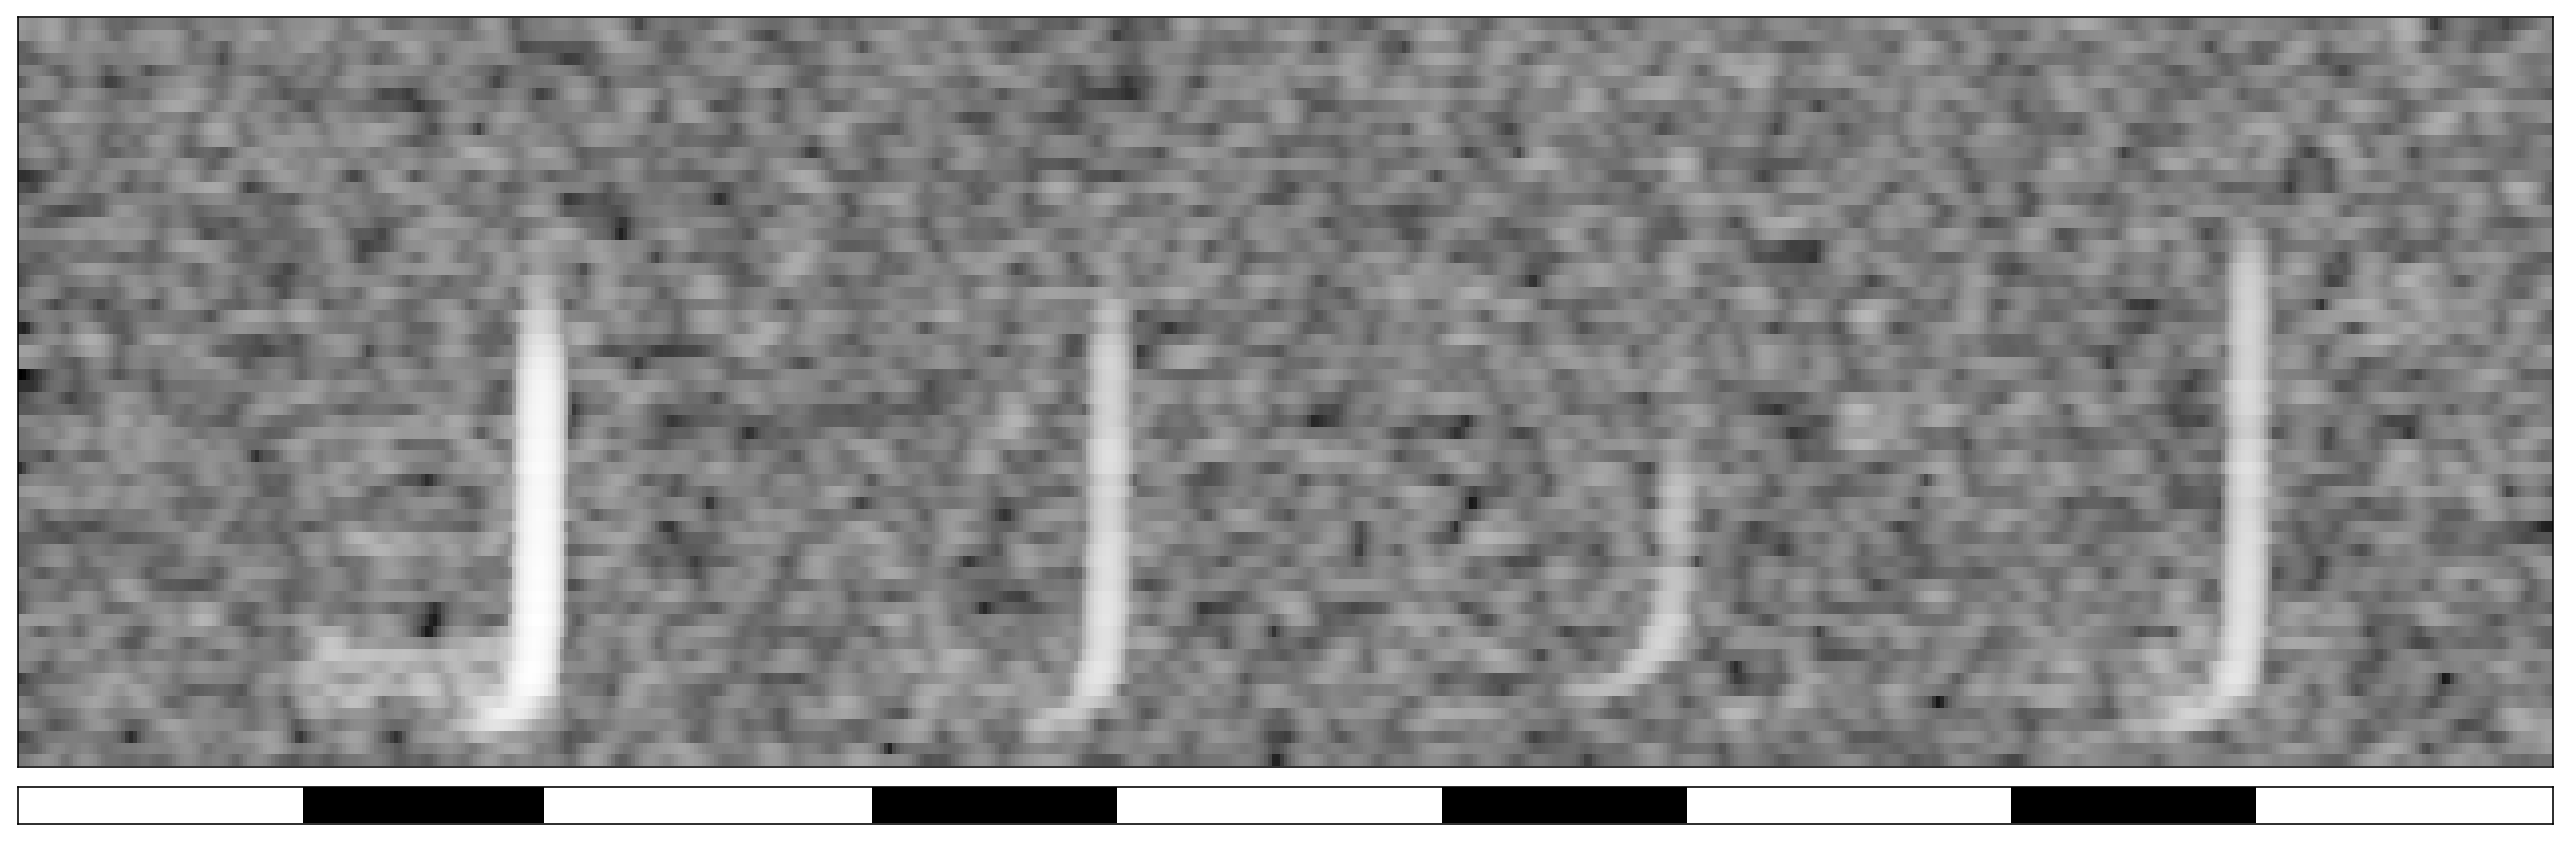

Spectrogram for L1:


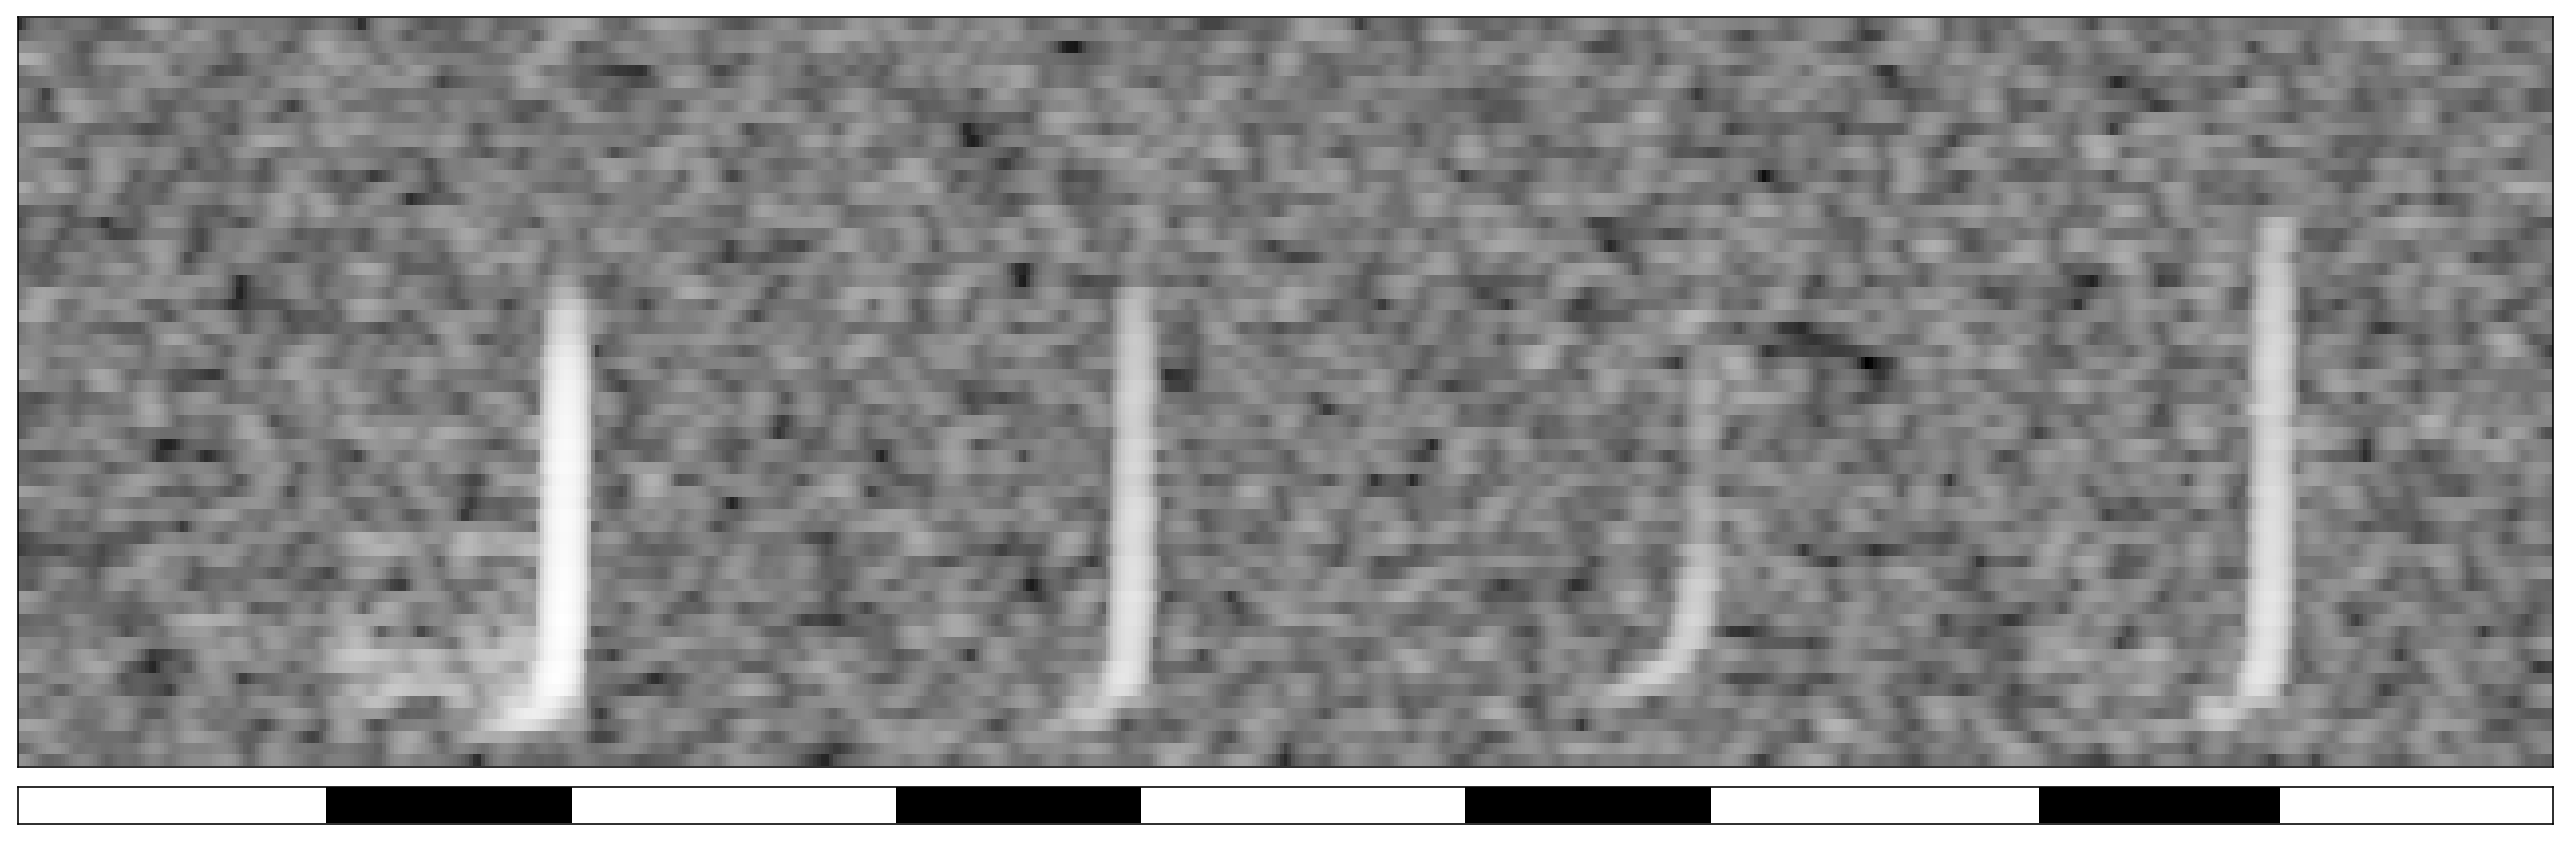

In [10]:
# Fix the seed of the RNG
np.random.seed(23)

# Create a spectrogram
spectrogram = Spectrogram(sample_length=sample_length, 
                          sampling_rate=sampling_rate, 
                          n_injections=n_injections,
                          waveforms=waveforms, 
                          psd=psd, 
                          max_delta_t=max_delta_t, 
                          loudness=loudness)

# Plot that spectogram
print('Spectrogram for H1:')
make_plot(spectrogram.spectrogram_H1, spectrogram.label_H1)
print('Spectrogram for L1:')
make_plot(spectrogram.spectrogram_L1, spectrogram.label_L1)

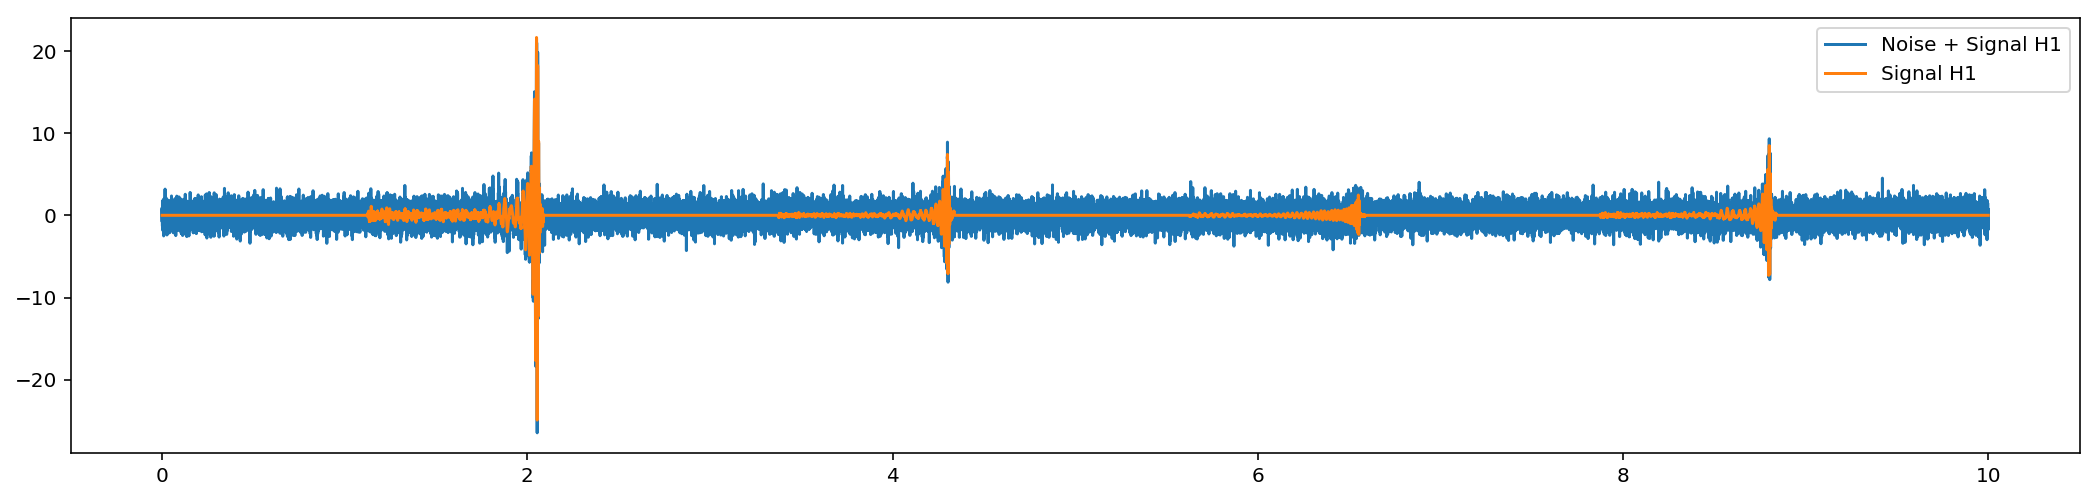

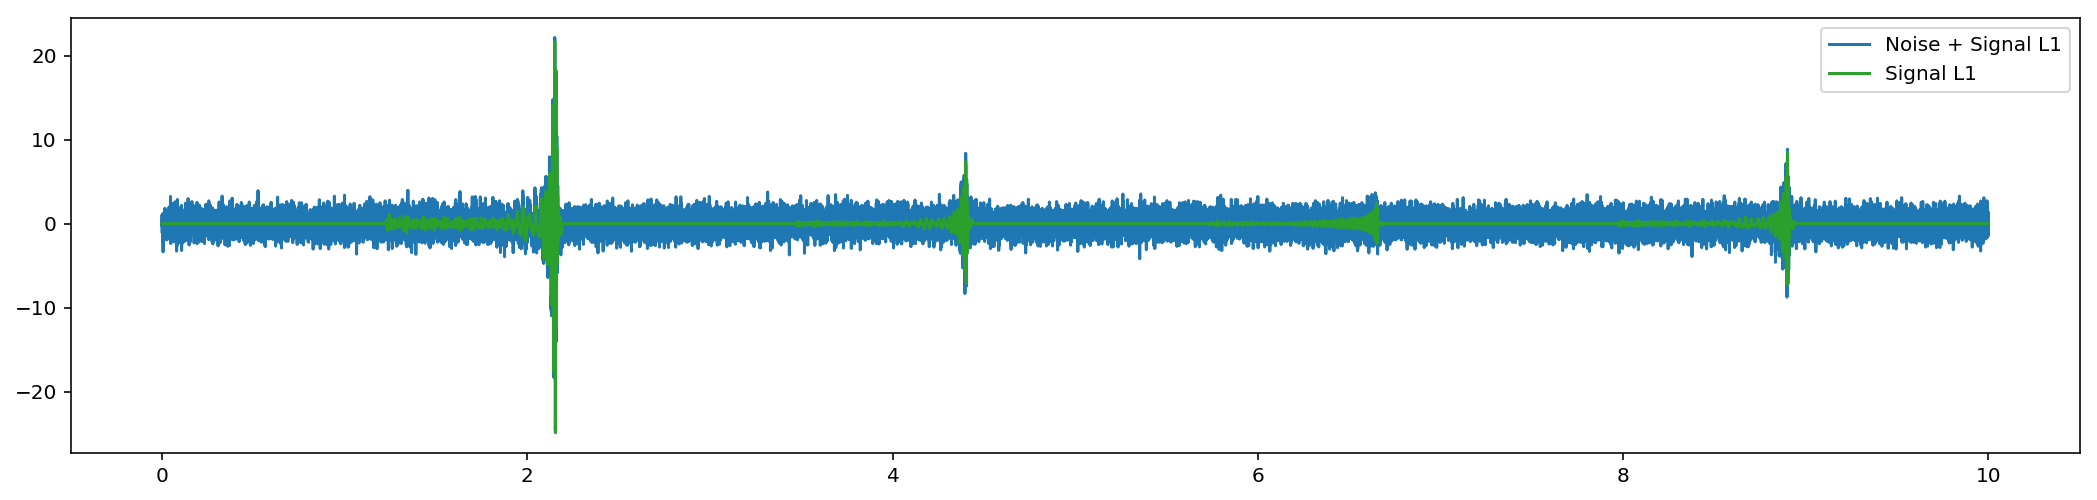

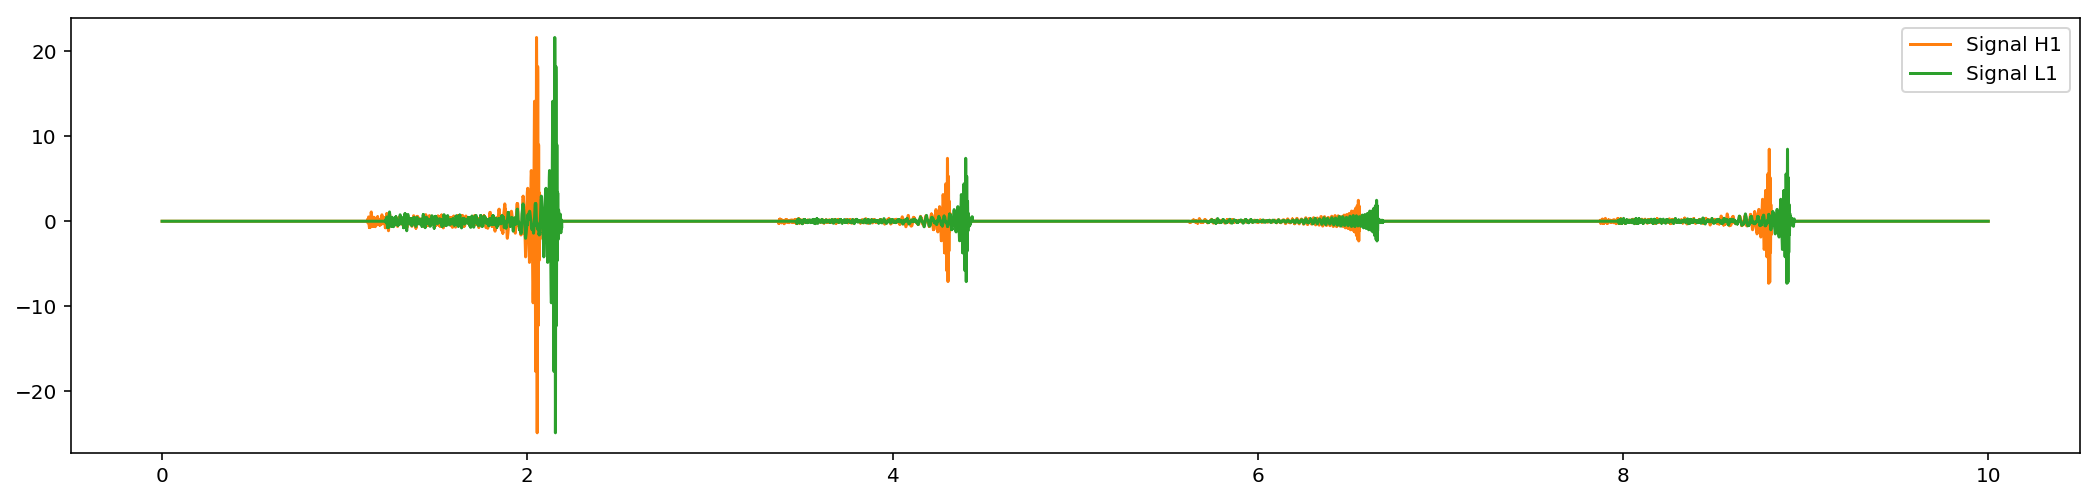

In [11]:
plt.figure(1)
plt.gcf().set_size_inches(18, 4, forward=True)
plt.plot([_/sampling_rate for _ in range(len(spectrogram.strain_H1))], spectrogram.strain_H1, label='Noise + Signal H1')
plt.plot([_/sampling_rate for _ in range(len(spectrogram.signal_H1))], spectrogram.signal_H1, label='Signal H1')
plt.legend(loc='best')

plt.figure(2)
plt.gcf().set_size_inches(18, 4, forward=True)
plt.plot([_/sampling_rate for _ in range(len(spectrogram.strain_L1))], spectrogram.strain_L1, label='Noise + Signal L1')
plt.plot([_/sampling_rate for _ in range(len(spectrogram.signal_L1))], spectrogram.signal_L1, c='C2', label='Signal L1')
plt.legend(loc='best')

plt.figure(3)
plt.gcf().set_size_inches(18, 4, forward=True)
plt.plot([_/sampling_rate for _ in range(len(spectrogram.signal_H1))], spectrogram.signal_H1, c='C1', label='Signal H1')
plt.plot([_/sampling_rate for _ in range(len(spectrogram.signal_L1))], spectrogram.signal_L1, c='C2', label='Signal L1')
plt.legend(loc='best')

plt.show()